In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au

TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
SAMPLE_RATE = 32000

In [14]:
csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
df = pd.read_csv(csv)
scenes = df.scene_preds.unique()

In [18]:
at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [23]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in df.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [27]:
df['audio_tags_org'] = audio_tags_org

In [67]:
import ast

csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds_withOrgTags.csv'
df = pd.read_csv(csv)
scenes = df['labels'].unique()
df['audio_tags_org'] = df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))

In [68]:
# Counting all the tags in the original audio
all_tags = set()

for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        all_tags.add(tag)

In [69]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(dict)
all_tags = list(all_tags)

for scene in scenes:
    for tag in all_tags:
        scene_tag_counts[scene][tag] = 0
    

In [70]:
# Counting the tags for each scene
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[row['labels']][tag] += 1

In [71]:
# Creating a dataframe
scene_tag_counts_df = pd.DataFrame.from_dict(scene_tag_counts, orient='index').transpose()

In [72]:
# Normalizing the counts
for scene in scenes:
    total = (scene_tag_counts_df[scene].sum())

    for index in scene_tag_counts_df.index:
        scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total

/tmp/ipykernel_1052072/40392073.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.005770816158285243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
/tmp/ipykernel_1052072/40392073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
/tmp/ipykernel_1052072/40392073.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00078003120124805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_tag_counts_df[scene][index] = (sce

In [73]:
better_all_tags = set()

for scene in scenes:
    for tag in all_tags:
        if (scene_tag_counts_df[scene][tag])>0.04:
            better_all_tags.add(tag)

In [74]:
valid_indices = [index for index in better_all_tags if index in scene_tag_counts_df.index]

better_df = pd.DataFrame(columns=scenes, index=valid_indices)

for scene in scenes:
    for tag in valid_indices:
        better_df[scene][tag] = scene_tag_counts_df[scene][tag]

In [75]:
#sns.heatmap(better_df, fmt='f', annot=True, cmap='Blues')
better_df = better_df.apply(pd.to_numeric)


<Axes: >

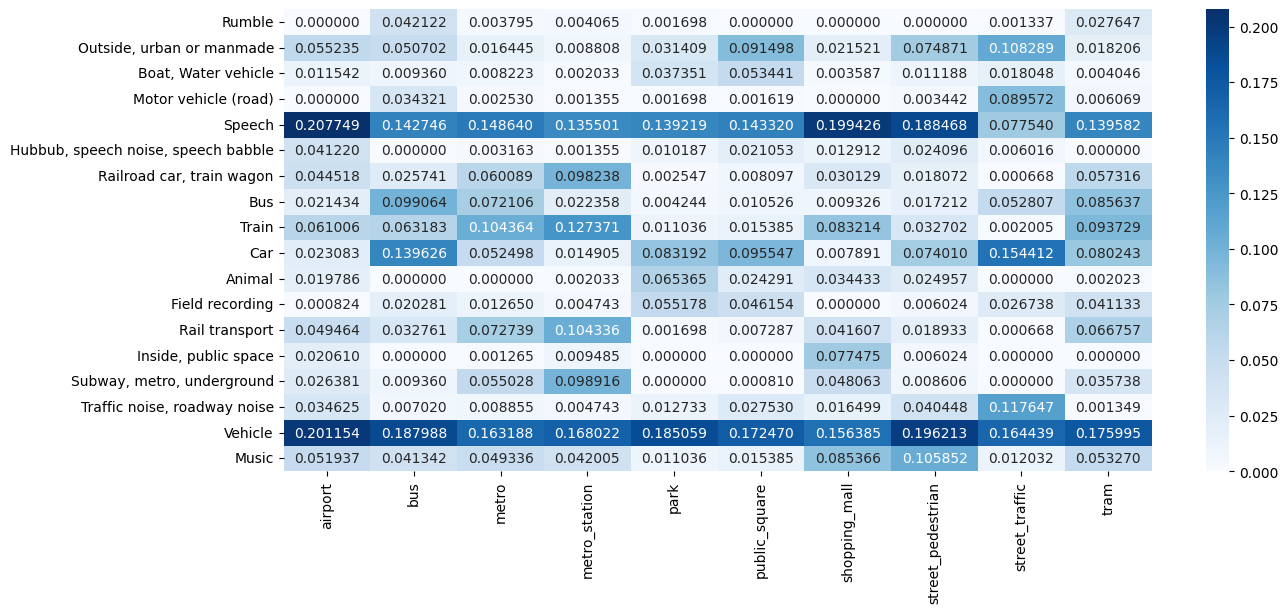

In [76]:
# We have to rethink this plot. We normalised it using the total number of events in all the files,
# Rather we should be normalising the frequency of each tag with the total number of files, which should give us a better representation
# That will give us an idea about the % of times a tag occured in a scene
plt.figure(figsize=(14,6))
sns.heatmap(better_df, fmt='f', annot=True, cmap='Blues')